# Interpretable home price predictions
### Lee Mackey & John Naujoks

In [1]:
# General setup imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Regression analysis tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from stepwise_selection import stepwise_selection
from sklearn.model_selection import cross_val_score

### Data Understanding

In [2]:
kc_housing = pd.read_csv('kc_house_data.csv')
kc_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Looking at columns type and if complete, and viewing which columns have null values that need to be addressed.
kc_housing.isna().sum(), kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64, None)

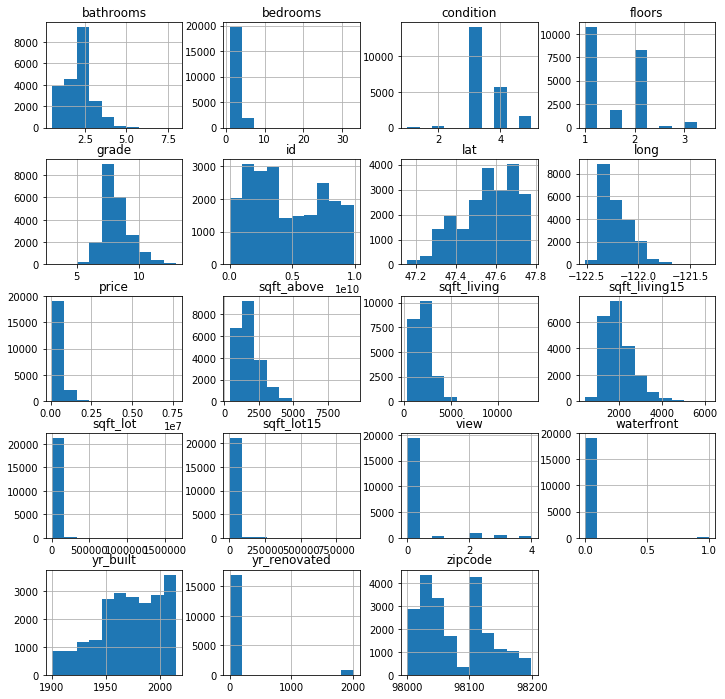

In [4]:
# A general view of the shape of our columns data
_ = kc_housing.hist(figsize=(12,12))

In [5]:
# A very large (and slow) scatter matrix to look at all the potential relationships.
potential_cols_1 = ['price','bedrooms','bathrooms','sqft_living',
                               'sqft_lot','floors', 'waterfront', 'view']

potential_cols_2 = ['price', 'condition','grade','sqft_above',
                    'sqft_basement','sqft_living15','sqft_lot15']

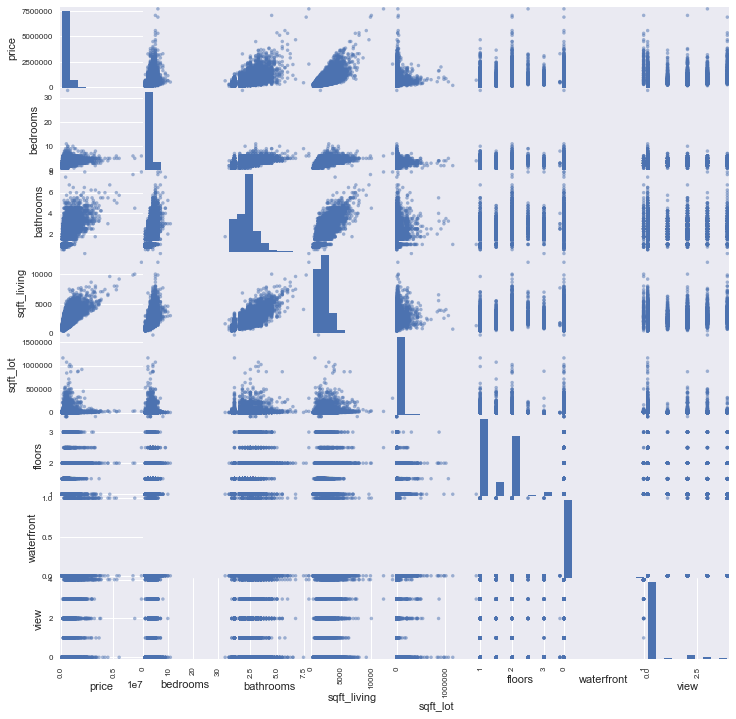

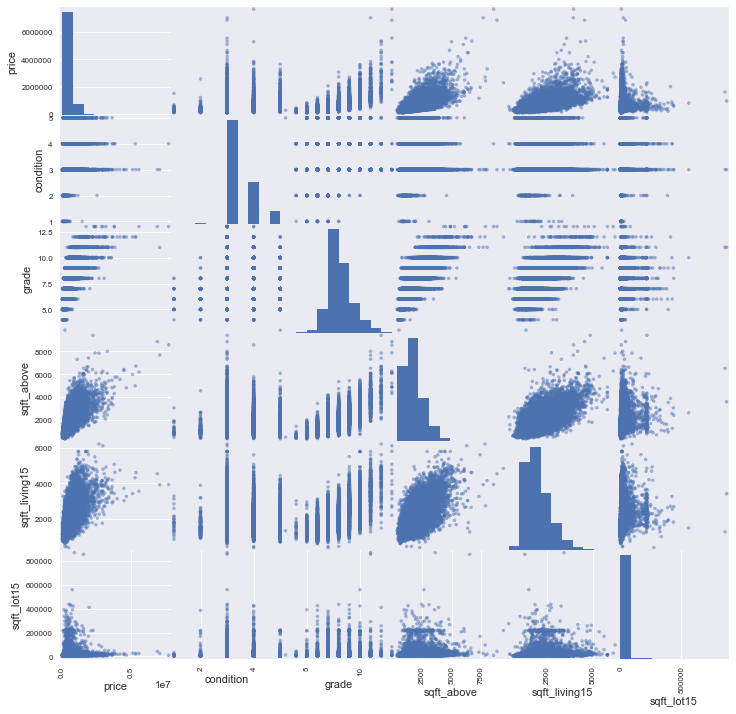

In [6]:
plt.style.use('seaborn')
_ = pd.plotting.scatter_matrix(kc_housing[potential_cols_1], figsize=(12,12))
_ = pd.plotting.scatter_matrix(kc_housing[potential_cols_2],figsize=(12,12))

#### Notes on results:
   - rectangular data structured as expected upon import
   - noted apparent presence of NaNs in 3 columns
   - apparent presence of non-normal distribution in target “price” column and some features

### Data Preparation

Dropping for now:
* Id: Does not feel necessary for our exploration and will drop this column
* Date: Going to use for some computations, but not do not need the variable on its own.
* Sqft_above: With ample other features for our property size, we decided to pass on using the characteristic for the time being as it is so highly correlated to other features that feel can significantly contribute to our model, like sqft_living.
* Latitude & Longitude: for location purses, we are going to do some exploring with the ZIP code.

In [7]:
kc_measures = kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

Cleaning NaN values:
* Waterfront: data is both incomplete and appears to be very primarily negative. Since the value is already binary, we are marking all the NaN values negative as to match to majority. Since it is so skewed, we will re-evaluate its utitlity later.
* Yr_renovated: To handle missing values, we collapsed this variable into binary for denoting renovation (True), or no value or no listed renovation year (False). Similar to waterfront, the majority did not have this value.
* View: The view variable has a couple issues. First, there are some null values in this column.  Since there are only 63 and we have a significant amount of other rows to work with, we dropped these rows.  Second, the value for 'view' seems like a small difference between those with and without views, so it felt more useful to collapse the granuality of number of views to a simple binary for "viewed" (True), "not viewed"(False)

In [8]:
kc_measures['waterfront'] = kc_measures['waterfront'].fillna(0.0)

kc_measures['renovated'] = np.where(kc_measures['yr_renovated']>0, 1, 0) 
kc_measures.drop('yr_renovated', axis=1, inplace=True)

kc_measures['view'] = kc_measures['view'].dropna(axis=0)
kc_measures['view'] = np.where(kc_measures['view']> 0, 1, 0)

Other data errors:
* Sqft_basement: In exploring this column, we found that some were marked with a question mark instead of a value. It appears that this column was a computation from sqft_living. Our decision was to test this variable as a binary value equating to having a basement(True), or no basement listed (False)

In [9]:
kc_measures['sqft_basement'] = kc_measures['sqft_basement'].str.replace('?', '0.0').astype('float')

In [10]:
kc_measures['basement'] = np.where(kc_measures['sqft_basement'] > 0, 1, 0)
kc_measures.drop('sqft_basement', axis=1, inplace=True)

Working with Zip Codes:
* We created dummy variables for each individual ZIP code.

In [11]:
df_zipcode_dums = pd.get_dummies(kc_measures['zipcode'], drop_first=True)
kc_measures_wzip = pd.concat([kc_measures, df_zipcode_dums], axis=1)

Creating a Feature from Year Built:
* Creating scalar values for the year value for "newness" of yr_built (absolute value of difference from 1900)

In [12]:
kc_measures['yr_built_scale'] = kc_measures['yr_built'].apply(lambda x: abs(1900 - x))
kc_measures.drop('yr_built', axis=1, inplace=True)

Further notes:
* Bedrooms: The data appears complete, though has some heavy outliers on the higher end (one with 33 bedrooms!) which may need to be min-max standardized
* Bathrooms: Comporable to bedrooms, may need to be adjusted for outliers, but complete.
* Yr_built: To make this column more useful, we are going to convert it into its age in years (subtract current year)
* Yr_renovated: data is fairly incomplete, so might want to skip
* Sqft Living 15: Based on the graphs, it looks like we might find some helpful relationship

Here are the key features we ran our modelling tests on:

In [13]:
len(kc_measures.columns)

16

In [14]:
kc_measures.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'renovated', 'basement', 'yr_built_scale'],
      dtype='object')

### Modeling

Our initial simple linear regression test:
* We put price on standard scale just to see the effect and get an RMSE that might be more proportionally readble. 

In [15]:
# Setting variables
X = kc_measures[['sqft_living']]
y = np.log(kc_measures[['price']])

In [16]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [17]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)

print(f"RMSE: {test_rmse}\nR2: {r2}")

RMSE: 0.38350683870644525
R2: 0.46397017759806614


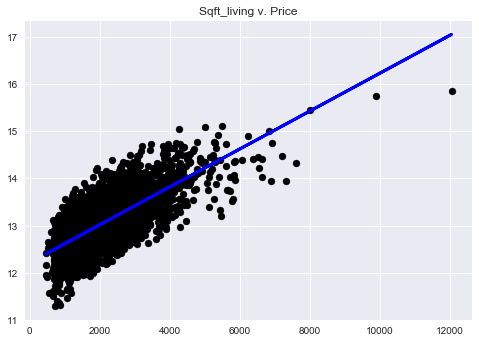

In [18]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

#### Log transformation on Price:
For the purposes of our model building, we decided it would be best to use the logged value of our prices for a couple of reasons: 
1. This form helps normalize our prices, as it is currently very positively skewed (as displayed below).
2. The metric we will receive from our modeling function becomes much more readable and coparable in running our analysis as well. In using the model for future interpretation, we would not keep this feature manipulated in this way. 

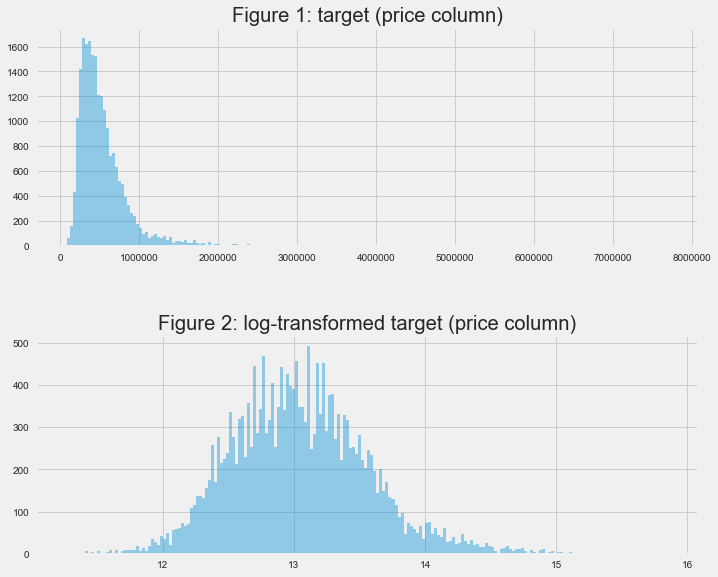

In [19]:
plt.style.use('fivethirtyeight')

X = kc_measures.price
X_log = np.log(kc_measures.price)
X = kc_measures.price

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

ax[0].hist(X, bins=200, alpha=0.4)
ax[1].hist(X_log, bins=200, alpha=0.4)
ax[0].set_title('Figure 1: target (price column)')
ax[1].set_title('Figure 2: log-transformed target (price column)')
plt.show()

#### Notes on results:
* On its own, sqft_living does appear to be on the right track of variables to help predict price, based on its scoring and a brief assessment of the visualization.
* Based on reviewing our data, we came up with an initial breakdown of looking at the features:
    * Structure - bedrooms, bathrooms, floors, condition, grade, renovated, basement, sqft_living, basement
    * Lot - sqft_lot, sqft_lot15, sqft_living15, waterfront, view
    * Location - zipcode

####  Creating some multivariate regression models

We made a quick function to help do the following for us:
1. Seperate out the Y ('price') and converting to log values (just for ease of reading) 
2. Setting our X (all other dataframe variables)
2. Create a train-test split on that data.
3. Run the training data through the linear regression function. 
4. Return a set of useful statistics to review their performance (R-Squared, MSE, RMSE, MAE)

In [20]:
def lin_regress_summary(df):

    y = np.log(df['price'])
    X = df.drop(['price'], axis=1)

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score
    r2 = r2_score(y_test, y_hat_test)
    print(f"the R^2 score is: {r2}")

    # See our Mean Squared Error
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    # See our Root Mean Squared Error
    test_rmse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_rmse}")
    
    # See our Mean Absolute Error
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")
    
    # Optional OLS test used to look into larger results, and check p-values
    # predictors_int = sm.add_constant(X)
    # results = sm.OLS(y,predictors_int).fit()
    # print(results.summary())
    # print(results.pvalues[results.pvalues > .05])

#### Testing all variables against price:

In [21]:
lin_regress_summary(kc_measures)

the R^2 score is: 0.6453978575522108
the test MSE is: 0.09655347185544044
the test RMSE is: 0.3107305454174733
the test MAE is: 0.24590531674458063


#### Testing all variables WITH all ZIP codes as dummy variables

In [22]:
lin_regress_summary(kc_measures_wzip)

the R^2 score is: 0.8749716238683237
the test MSE is: 0.03448523546510779
the test RMSE is: 0.18570200716499483
the test MAE is: 0.13653960856043787


Based just on this initial assessment, it appeared that the ZIP codes were a great help to improving our model, both in its representativeness to the data (R^2) and its potential for model prediction (RMSE & MAE).

With that knowledge, we began running several iterations of our variables without the ZIP codes to find the strongest ones, and then adding them along with our ZIP code variables.

First, a couple models based on that simple seperation of characteristics:

In [23]:
kc_m_lot = kc_measures[['price','sqft_lot', 'waterfront', 'view',
                        'sqft_living15','sqft_lot15', ]]

In [24]:
lin_regress_summary(kc_m_lot)

the R^2 score is: 0.4081017148846463
the test MSE is: 0.16426808096981518
the test RMSE is: 0.40529998885987545
the test MAE is: 0.32161634438361014


In [25]:
kc_m_structure = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                              'floors', 'condition', 'grade', 'renovated', 'basement']]

In [26]:
lin_regress_summary(kc_m_structure)

the R^2 score is: 0.5940386794426102
the test MSE is: 0.11729520389689137
the test RMSE is: 0.3424838739223956
the test MAE is: 0.2712682840944508


Next, we took a quick look at the results of a stepwise selector (function originally found on Learn.co, modified to take in a dataframe, know the 'price' is our key variable, and test the rest):

In [27]:
stepwise_selection(kc_measures)

['grade',
 'yr_built_scale',
 'sqft_living',
 'waterfront',
 'view',
 'bedrooms',
 'bathrooms',
 'sqft_lot15',
 'condition',
 'floors',
 'sqft_living15',
 'renovated',
 'basement']

In [28]:
kc_m_step_results = kc_measures[['price','bedrooms', 'bathrooms','sqft_living',
                                 'floors','waterfront', 'view', 'condition','grade',
                                 'sqft_living15', 'sqft_lot15', 'renovated', 'basement',
                                 'yr_built_scale']]

In [29]:
lin_regress_summary(kc_m_step_results)

the R^2 score is: 0.6580385070559231
the test MSE is: 0.09560543180129362
the test RMSE is: 0.30920128040047573
the test MAE is: 0.2461627935614534


Based on these results, ran several more tests and tried a number of different configurations:

In [30]:
kc_m_var_1 = kc_measures[['price', 'waterfront','grade','yr_built_scale',
                          'bathrooms', 'sqft_living','bedrooms']]

In [31]:
lin_regress_summary(kc_m_var_1)

the R^2 score is: 0.6433221917786385
the test MSE is: 0.09829969242403391
the test RMSE is: 0.3135278176239453
the test MAE is: 0.2493239355550569


In [32]:
kc_m_var_2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_scale']]

In [33]:
lin_regress_summary(kc_m_var_2)

the R^2 score is: 0.6573904554830703
the test MSE is: 0.09945553889507079
the test RMSE is: 0.31536572244787603
the test MAE is: 0.2500156853777593


In [34]:
kc_m_var_3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_scale']]

In [35]:
lin_regress_summary(kc_m_var_3)

the R^2 score is: 0.635426810228529
the test MSE is: 0.10183634313099288
the test RMSE is: 0.3191180708311469
the test MAE is: 0.25397152495692693


In [36]:
kc_m_var_4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_scale']]

In [37]:
lin_regress_summary(kc_m_var_4)

the R^2 score is: 0.6552923201819965
the test MSE is: 0.0969469681698949
the test RMSE is: 0.31136308093589854
the test MAE is: 0.2476161701526224


In [38]:
kc_m_var_5 = kc_measures[['price', 'bedrooms', 'sqft_living','waterfront',
                          'view', 'grade', 'yr_built_scale']]

In [39]:
lin_regress_summary(kc_m_var_5)

the R^2 score is: 0.6236320086193868
the test MSE is: 0.10799171951582676
the test RMSE is: 0.32862093590613906
the test MAE is: 0.26346780542081755


With keeping in mind some of what we saw from our model tests, we ran further tests including our ZIP code dummy variables combined with our other variable measures:

In [40]:
kc_use_6 = kc_measures[['price','waterfront', 'view', 'bedrooms',
                      'sqft_living', 'grade', 'renovated','yr_built_scale']]
kc_m_var_6 = pd.concat([kc_use_6, df_zipcode_dums], axis=1)

In [41]:
lin_regress_summary(kc_m_var_6)

the R^2 score is: 0.8594561090519891
the test MSE is: 0.03665981542582365
the test RMSE is: 0.1914675309963119
the test MAE is: 0.13995575086956838


In [42]:
kc_use_7 = kc_measures[['price', 'waterfront','grade','yr_built_scale',
                          'bathrooms', 'sqft_living','bedrooms']]
kc_m_var_7 = pd.concat([kc_use_7, df_zipcode_dums], axis=1)

In [43]:
lin_regress_summary(kc_m_var_7)

the R^2 score is: 0.8637649927339216
the test MSE is: 0.037252753540293025
the test RMSE is: 0.19300972395268853
the test MAE is: 0.14218021184946206


#### Notes of results:

Based on all our variations, it appears that our model for "kc_m_var_6" has the best potential.  From here, we will further check and test our model.



### Evaluation

##### Does my selection of features have any excessive multicollinearity?
To check our other selected variables, we are looked for multicollinearity through the table below and explored the heatmap:

In [44]:
kc_use_6.corr()

,price,waterfront,view,bedrooms,sqft_living,grade,renovated,yr_built_scale
price,1.000000,0.264306,0.356243,0.308787,0.701917,0.667951,0.117543,0.053953
waterfront,0.264306,1.000000,0.248683,-0.002127,0.104637,0.082818,0.074267,-0.024487
view,0.356243,0.248683,1.000000,0.079232,0.268465,0.235252,0.081407,-0.063826
bedrooms,0.308787,-0.002127,0.079232,1.000000,0.578212,0.356563,0.017635,0.155670
sqft_living,0.701917,0.104637,0.268465,0.578212,1.000000,0.762779,0.050829,0.318152
grade,0.667951,0.082818,0.235252,0.356563,0.762779,1.000000,0.015259,0.447865
renovated,0.117543,0.074267,0.081407,0.017635,0.050829,0.015259,1.000000,-0.202837
yr_built_scale,0.053953,-0.024487,-0.063826,0.155670,0.318152,0.447865,-0.202837,1.000000


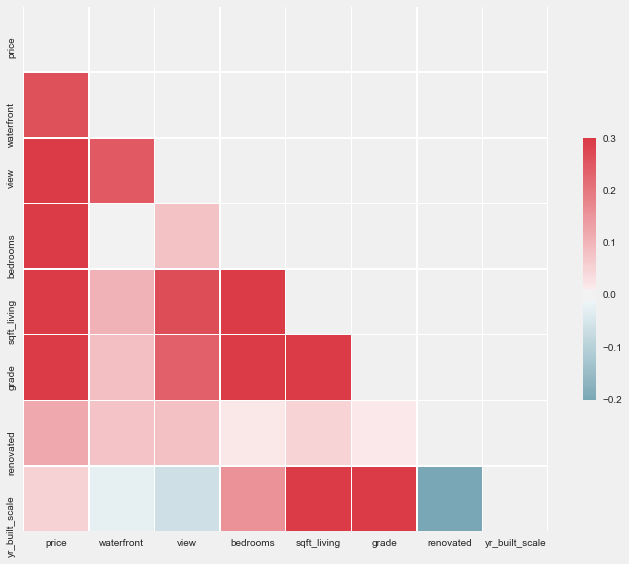

In [45]:
#Heatmap view of how the variables relate:
corr = kc_use_6.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

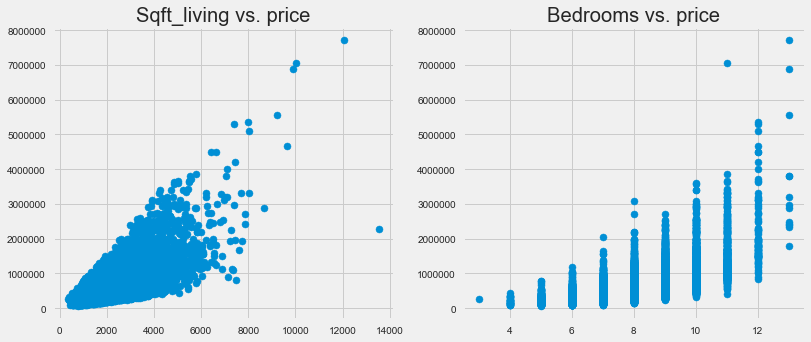

In [46]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(kc_use_6['sqft_living'], kc_use_6['price'])
ax[0].set_title("Sqft_living vs. price")

ax[1].scatter(kc_use_6['grade'], kc_use_6['price'])
ax[1].set_title("Bedrooms vs. price")

plt.show()

Based on this information, it appears that 'grade' is highly correlated with 'sqft_living', which does intrinsically make sense. To conteract that, we decided to drop that feature from our model.

In [47]:
kc_model = kc_measures[['price','waterfront','sqft_living', 'renovated', 'yr_built_scale']].copy()

kc_model_complete = pd.concat([kc_model,df_zipcode_dums], axis=1)

##### How are my p-values?
To further make sure this model is sound, we checked the p-values:

In [48]:
y = np.log(kc_model_complete['price'])
X = kc_model_complete.drop(['price'], axis=1)

predictors_int = sm.add_constant(X)
results = sm.OLS(y,predictors_int).fit()
print(results.pvalues[results.pvalues > .05])

98023    0.384206
98032    0.107181
98168    0.851311
dtype: float64


It appears we have found some ZIP codes with p-values greater than .05. We will drop them to improve our model:

In [49]:
kc_model_complete.drop([98023, 98032, 98168], axis=1, inplace=True)

In [50]:
lin_regress_summary(kc_model_complete)

the R^2 score is: 0.8312820560977965
the test MSE is: 0.047251086084172965
the test RMSE is: 0.21737314940942676
the test MAE is: 0.1575475182359445


The changes to our model did effect our key metrics, but in checking with some of our other model options, this configuration is still the cleanest and our best option.

#### Testing K-Folds Cross Validation

In [51]:
y = np.log(kc_model_complete['price'])
X = kc_model_complete.drop(['price'], axis=1)

In [52]:
# Perform K-Folds
cv_results_5_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                        cv=5, scoring='neg_mean_absolute_error'))))
cv_results_5_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=5, scoring="neg_mean_absolute_error")))
cv_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                         cv=10, scoring="neg_mean_squared_error"))))
cv_results_10_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=10, scoring="neg_mean_absolute_error")))
cv_results_20_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X, y,
                                                         cv=20, scoring="neg_mean_squared_error"))))
cv_results_20_MAE = np.mean(abs(cross_val_score(linreg, X, y,
                                                cv=20, scoring="neg_mean_absolute_error")))

print(f"K-Fold Cross Val 5 RMSE: {cv_results_5_RMSE}, MAE: {cv_results_5_MAE} ")
print(f"K-Fold cross val 10 RMSE: {cv_results_10_RMSE}, MAE: {cv_results_10_MAE}")
print(f"K-Fold cross val 20 RMSE: {cv_results_20_RMSE}, MAE: {cv_results_20_MAE}")

K-Fold Cross Val 5 RMSE: 0.39708550050447394, MAE: 0.15771173427945948 
K-Fold cross val 10 RMSE: 0.21524155198855813, MAE: 0.15760969611334072
K-Fold cross val 20 RMSE: 0.21498804221035886, MAE: 0.15751436043522507


#### Notes on results:
* Our evaluation steps provided some additional considerations and altered some of our models features. Overall, through further validation, our model still appears to be our strongest option to help predict home price in the future.

### Deployment

Here are the final statistics for our model:

In [53]:
y = np.log(kc_model_complete['price'])
X = kc_model_complete.drop(['price'], axis=1)

predictors_int = sm.add_constant(X)
results = sm.OLS(y,predictors_int).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1546.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:15:23   Log-Likelihood:                 2608.0
No. Observations:               21597   AIC:                            -5074.
Df Residuals:                   21526   BIC:                            -4507.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.8271      0.008   1524.

##### Graveyard of Features

The following are a seleciton of features we drafted, modeled with other variables, and found not a significant enough impact to include in our model.

#### Yard Size: all square footage outside of the living area (Sqft_Living - Sqft_Lot)

In [54]:
# kc_measures['yard'] = kc_measures['sqft_living'] - kc_measures['sqft_lot']

#### Seasons: taking the month sold during the year and grouping into four seasons. Tried just months as well, but sales were fairly even by month.

In [55]:
# kc_mod['month'] = kc_mod['date'].apply(lambda x: x[:2]).str.replace('/','').astype(int)

# def quarter(val):
#     if val in range(3):
#         return '1-3'
#     elif val in range(4,7):
#         return '4-6'
#     elif val in range(7,10):
#         return '7-9'
#     elif val in range(10,13):
#         return '10-12'
    
# kc_mod['month'] = kc_mod['month'].apply(lambda x: quarter(x))
# kc_mod['month'].value_counts()
# df_month_dums = pd.get_dummies(kc_mod['month'])
# kc_mod = pd.concat([kc_mod, df_month_dums], axis=1)

#### Distance from Expensive neighborhoods: Based on article found from 2017 with most expensive neighborhoods, create values for distance from those expensive neighborhood centers.  This method we did not finish testing, but feel that some of its subtley may be picked up in ZIP codes 

<a href="https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home">Original article<a>

In [56]:
# Test for location close to expensive areas
# kc_loc = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_loc['loc'] = (kc_loc['lat'] + 90) * (180 + kc_loc['long'])
# kc_loc.drop(['lat','long'], axis=1, inplace=True)
#location = (lat + 90) * 180 + long

# downtown = (47.60806 + 90) * (180 + -122.33611)

# madrona = (47.613274 + 90) * (180 + -122.28887)
# slu = (47.62343 + 90) * (180 + -122.33435)
# eastlake = (47.64708 + 90) * ( 180 + -122.32477)
# queen_anne = (47.63692 + 90) * (180 + -122.35579)
# magnolia = (47.65056 + 90) * (180 + -122.40083)
# first_hill = (47.60864 + 90) *(180 + -122.32679)

# #location = (lat + 90) * 180 + long

# kc_expensive = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_expensive['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_loc['loc_downtown'] = kc_loc['loc'].apply(lambda x: abs(x - downtown))

# kc_expensive['loc_madrona'] = kc_expensive['loc'].apply(lambda x: x - madrona)
# kc_expensive['loc_slu'] = kc_expensive['loc'].apply(lambda x: x - slu)
# kc_expensive['loc_eastlake'] = kc_expensive['loc'].apply(lambda x: x - eastlake)
# kc_expensive['loc_queen_anne'] = kc_expensive['loc'].apply(lambda x: x - queen_anne)
# kc_expensive['loc_magnolia'] = kc_expensive['loc'].apply(lambda x: x - magnolia)
# kc_expensive['loc_first_hill'] = kc_expensive['loc'].apply(lambda x: x - first_hill)

#### In Seattle: Trying a simple binary "In Seattle"-> True, "Not Seattle"-> False. A slimmer option, but might not provide the subltey of neighborhood variation. In running tests of both this metric and ZIP codes as dummy variables, we found Zip code dummies to more positively effect the metrics we were monitoring (R-Squared & RMSE), so we went with the dummy variables.  Below shows the process used for the "In Seattle" variation.

In [57]:
# seattle_zips = [98101, 98102, 98104, 98105, 98108, 98109, 98112, 98113, 98114, 98117, 98103, 98106, 98107,
#                 98111, 98115, 98116, 98118, 98119,98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 
#                 98122, 98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148, 98155, 98160, 98161, 
#                 98164, 98165, 98168, 98170, 98146, 98154, 98158, 98166, 98174, 98175, 98178, 98190, 98191,
#                 98177, 98181, 98185, 98188, 98189, 98194, 98195, 98199,98198]

# kc_measures['in_seattle'] = kc_measures['zipcode'].map(lambda x: 1 if x in seattle_zips else 0)
# kc_measures.drop('zipcode', axis=1, inplace=True)